## Mathematical Modeling of NET-Seq Signals

**Dwell-time and Flux Coupling**: Let $S(x)$ be the NET-Seq signal at position $x$. At low RNAP density, 

$$
S(x) = D(x) \cdot j(x) \tag{1}
$$

where $D(x)$ is the dwell time of the RNAP at position $x$ and $j(x)$ is the flux of RNAPs at position $x$. 

**Continuity Equation for flux**: If $j(x)$ is the flux of RNAPs at position $x$, and $\gamma(x)$ is the termination probability per position $x$ traversed (RNAP loss), then the flux satisfies the continuity equation (assuming there's no net RNAP accumulation)

$$
\frac{\text{d} j(x)}{\text{d}x} = -\gamma(x) \, j(x) \tag{2}
$$

Hence, *at low RNAP density and no net RNAP accumulation*, 

$$
S(x) = D(x) \, j(0) \exp \left[-\int_{0}^{x} \gamma(x') \, dx'\right] \tag{3}
$$

*Note: I don't think this is necessarily true for high RNAP density or when you include queueing effects like in TASEP, but to a first approximation this should be a good model. We can further extend this however.* 

**Motivation**: The issue with the current TASEP code is that it assumes the dwell time information $D(x)$ from the NET-seq data $S(x)$ to reconstruct $S_{sim}(x)$. This assumes that the flux $j(x)$ is constant, which is not true.

### Motivation: What does $j(x)$ look like?

Consider the Rho-dependent termination model (PT\_Model=2) implemented in the TASEP simulation. The per-position termination probability is proportional to the length of exposed (ribosome-unprotected) nascent RNA:

$$
\gamma(x) = \frac{K_{\text{Rut}}}{L} \cdot \max\!\Big(0,\; x - x_{\text{ribo}} - \ell_{\text{RNAP}} - \ell_{\min}\Big) \tag{M1}
$$

where $K_{\text{Rut}} = 0.13$ is the Rho loading parameter, $L$ is the gene length, $\ell_{\text{RNAP}} = 35$ bp is the RNAP footprint, and $\ell_{\min} = 50$ bp is the minimum exposed RNA for Rho loading.

For a **weakly coupled** gene (low translation efficiency, ribosome absent or far behind), $x_{\text{ribo}} \approx 0$, so the exposed RNA grows linearly with $x$:

$$
\gamma(x) \approx \frac{K_{\text{Rut}}}{L}\,(x - \ell_0) \quad \text{for } x > \ell_0 = \ell_{\text{RNAP}} + \ell_{\min} \tag{M2}
$$

Integrating the continuity equation (2) with this linearly increasing hazard:

$$
j(x) = j(0)\,\exp\!\left(-\frac{K_{\text{Rut}}}{2L}\,(x - \ell_0)^2\right) \quad \text{for } x > \ell_0 \tag{M3}
$$

This is a **Gaussian-shaped flux decay**, gentle near the promoter, accelerating toward the 3' end. Below we plot this for *insQ* ($L = 1150$ bp, TE $= 0.11$, $K_{\text{Rut}} = 0.13$).

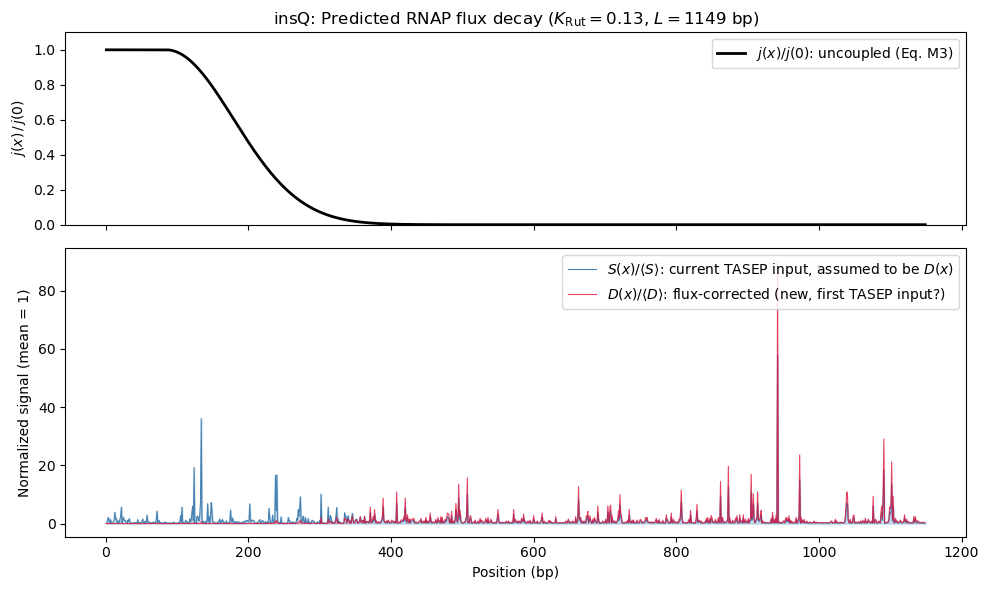

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# insQ parameters
K_rut = 0.13       # Rho loading parameter
ell_RNAP = 35      # RNAP footprint (bp)
ell_min = 50       # minimum exposed RNA for Rho loading (bp)
ell_0 = ell_RNAP + ell_min  # onset position

# Load insQ NET-seq signal and derive gene length from data
S = np.loadtxt("NETSEQ_gene/NETSEQ_insQ.csv", delimiter=",")
L = len(S)
x = np.arange(1, L + 1)

# Flux shape j(x)/j(0) from Eq. (M3): Gaussian decay for uncoupled case
# Note: we only know the *shape* of j(x), not its absolute value.
# D(x) = S(x)/j(x) = S(x) / [j(0) * j(x)/j(0)] = S(x) / j_shape(x) * (1/j(0))
# The constant 1/j(0) cancels when we normalize D(x) by its mean for TASEP input.
j_shape = np.ones(L)
mask = x > ell_0
j_shape[mask] = np.exp(-K_rut / (2 * L) * (x[mask] - ell_0)**2)

# Regularize: clamp flux shape to avoid division blow-up where j -> 0
j_floor = 0.01
j_shape_reg = np.maximum(j_shape, j_floor)

# Flux-corrected dwell time estimate
D_corrected = S / j_shape_reg

# Normalize both by their means for shape comparison
# (TASEP input is always mean-normalized, so this is what matters)
S_norm = S / np.mean(S)
D_norm = D_corrected / np.mean(D_corrected)

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [1, 1.5]})

# Top panel: flux decay
axes[0].plot(x, j_shape, "k-", lw=2, label=r"$j(x)/j(0)$: uncoupled (Eq. M3)")
#axes[0].axhline(j_floor, color="gray", ls="--", lw=0.8, label=f"regularization floor = {j_floor}")
axes[0].set_ylabel(r"$j(x)\,/\,j(0)$")
axes[0].set_ylim(0, 1.1)
axes[0].legend(loc="upper right")
axes[0].set_title(f"insQ: Predicted RNAP flux decay ($K_{{\\mathrm{{Rut}}}}={K_rut}$, $L={L}$ bp)")

# Bottom panel: mean-normalized shapes
axes[1].fill_between(x, S_norm, alpha=0.25, color="steelblue")
axes[1].plot(x, S_norm, color="steelblue", lw=0.8, label=r"$S(x)/\langle S \rangle$: current TASEP input, assumed to be $D(x)$")
axes[1].plot(x, D_norm, color="crimson", lw=0.8, alpha=0.8,
            label=r"$D(x)/\langle D \rangle$: flux-corrected (new, first TASEP input?)")
axes[1].set_xlabel("Position (bp)")
axes[1].set_ylabel("Normalized signal (mean = 1)")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Some other considerations

### Consideration 1: Dwell Time and Sequence-Dependent Elongation

The dwell time $D(x)$ encodes how long an RNAP pauses at position $x$. Two options for modeling its sequence dependence:

---

**Option A — Arrhenius / energy landscape model:**

$$
D(x) = \frac{1}{k(x)}, \qquad k(x) = k_0 \exp\!\left[-\frac{\Delta G(x)}{RT}\right] \tag{4a}
$$

where $\Delta G(x)$ is a sequence-specific free energy barrier at position $x$, $k_0$ is the basal elongation rate, and $RT$ is thermal energy. This assumes each translocation step is an activated process over a local energy landscape set by the DNA/RNA hybrid and downstream DNA sequence.

---

**Option B — Additive pause-motif model:**

$$
D(x) = D_0 + \sum_{i \in \text{pause motifs}} \delta_i(x) \, \Delta D_{\text{motif},i} \tag{4b}
$$

where $D_0$ is the baseline dwell time, $\delta_i(x)$ is the indicator function for the presence of pause motif $i$ at position $x$, and $\Delta D_{\text{motif},i}$ is the additional dwell time contributed by that motif. I think this is a simpler, more empirical approach, directly parameterized by known pause-inducing sequences (e.g., *his*, elemental pause motifs).

### Consideration 2: Transcription-Translation Coupling

In bacteria, the trailing ribosome can couple to the elongating RNAP. Let $C(x) \in [0, 1]$ denote the **coupling function**, where $C(x) = 1$ means the RNAP at position $x$ is fully coupled to a trailing ribosome and $C(x) = 0$ means fully uncoupled.

*Note*: $C(x)$ is expected to be low in the **promoter-proximal window** because the ribosome must first recognize the Shine-Dalgarno sequence, initiate translation, and catch up to the RNAP before coupling is established.

---

**Option A: Coupling directly reduces dwell time $D(x)$**

The trailing ribosome prevents RNAP backtracking and pushes it through pause sites, reducing the effective dwell time:

$$
D_{\text{coupled}}(x, \varepsilon, C) = D_{\text{uncoupled}}(x)\left[1 - \varepsilon \, C(x)\right] \tag{5}
$$

where $\varepsilon \in [0,1]$ is the **maximal fractional reduction in pause duration** due to coupling. When $\varepsilon \, C(x) \to 1$, pausing is fully suppressed; when $C(x) = 0$ (uncoupled), $D$ reverts to the intrinsic profile.

---

**Option B: Coupling reduces the termination hazard $\gamma(x)$**

Rather than (or in addition to) speeding up elongation, coupling protects the nascent RNA from Rho factor by occluding *rut* sites, thereby lowering the premature termination rate:

$$
\gamma_{\text{coupled}}(x, C) = \gamma_{\text{uncoupled}}(x)\left[1 - C(x)\right] \tag{6}
$$

When the ribosome is fully coupled ($C(x) = 1$), the exposed nascent RNA length is minimal and Rho cannot load, so $\gamma \to 0$. When uncoupled ($C(x) = 0$), the full intrinsic termination rate applies.

### Consideration 3: Premature Termination / Attenuation by Hairpin (Intrinsic)?

Intrinsic terminators act at a discrete hairpin site $x_{\text{hp}}$. The termination hazard is modeled as a point process:

$$
\gamma_{\text{hp}}(x) = k_{\text{hp}} \, \delta(x - x_{\text{hp}}) \tag{7}
$$

where:
- $x_{\text{hp}}$ is the hairpin start site (terminator location)
- $k_{\text{hp}} \in [0,1]$ is the fraction of RNAPs terminated upon encountering the hairpin

### Consideration 4: Rho-Dependent Premature Termination (*rut* Sites)

**Discrete *rut* site:**

$$
\gamma_{\text{rut}}(x) = k_{\text{rut}} \, \delta(x - x_{\text{rut}}) \tag{8b}
$$

where $x_{\text{rut}}$ is the *rut* start site and $k_{\text{rut}}$ is the termination efficiency at that site. This treats Rho termination analogously to intrinsic termination — a point event at a defined location.